# ShapGPT

After checking out different machine learning methods to catch fraud, I started wondering about what factors influenced the models in making specific predictions. I began to ask myself if there's a way to really understand what's behind these predictions. After some reasearch I came across SHAP values (Explained later) which do a great job of interpretting models outputs, but I still thought there could be a more user-friendly, slightly less technical, medium to output the response. Which is when I thought about combining the shap value outputs with ChatGPT to provide a text description.

One key use case that comes to mind involves banks employing Artificial Intelligence models to evaluate loan or credit applications. Instead of getting a single answer from a mysterious black box, this could offer a pre-written explanation of the model's decision that can be directly incorporated into a response document or file.

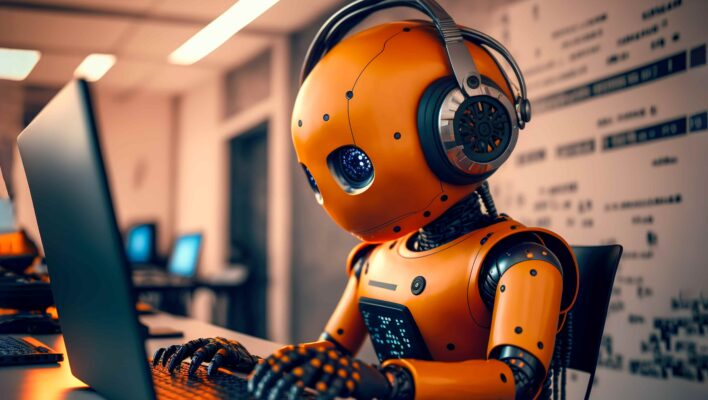

In [9]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt
import openai 
import textwrap

In [10]:
# Choose plot ftyle to be used
plt.style.use('rose-pine')

In [11]:
# Full Data was +1m rows so using a sample for predictions
raw_sample = pd.read_csv(r"sample_data.csv")

In [12]:
# Check number of fraud and non fraud records
raw_sample['fraud_bool'].groupby(raw_sample['fraud_bool']).count()

fraud_bool
0    491
1      9
Name: fraud_bool, dtype: int64

In [13]:
# Find the index of the fraudulent records
raw_sample[raw_sample['fraud_bool'] == 1]

,Unnamed: 0,fraud_bool,credit_risk_score,current_address_months_count,log_zip_count_4w,zip_count_4w,date_of_birth_distinct_emails_4w,bank_branch_count_8w,income,month,...,proposed_credit_limit,device_distinct_emails_8w,housing_status_BA,employment_status_CA,source_INTERNET,phone_mobile_valid,device_os_windows,keep_alive_session,email_is_free,log_prev_address_months_count
27,97976,1,0.778175,0.337995,0.840171,0.291237,0.333333,0.000419,1.000,0.428571,...,0.685864,0.666667,True,True,True,1,True,0,0,0.0
30,620567,1,0.756708,0.149184,0.754080,0.149724,0.358974,0.000000,0.875,0.000000,...,0.685864,0.666667,False,False,True,0,True,0,1,0.0
78,753126,1,0.610018,0.508159,0.874081,0.378415,0.153846,0.000419,1.000,0.714286,...,0.005236,0.666667,True,True,True,0,False,0,0,0.0
120,248278,1,0.576029,0.142191,0.876159,0.384535,0.307692,0.000000,1.000,0.285714,...,0.005236,1.000000,False,True,True,1,True,1,1,0.0
268,385405,1,0.436494,0.237762,0.921341,0.545007,0.205128,0.000000,0.125,0.142857,...,0.005236,0.333333,True,True,True,0,False,0,0,0.0
300,248125,1,0.341682,0.496503,0.771315,0.171070,0.358974,0.000839,0.000,0.285714,...,0.424084,0.666667,False,False,True,1,False,0,0,0.0
435,753659,1,0.669052,0.158508,0.709438,0.105986,0.128205,0.000000,1.000,0.714286,...,0.162304,0.666667,True,True,True,1,True,0,1,0.0
460,513461,1,0.860465,0.268065,0.851416,0.317659,0.076923,0.000839,0.000,0.857143,...,0.005236,0.666667,False,True,True,1,True,1,1,0.0
464,753668,1,0.409660,0.291375,0.748684,0.143604,0.179487,0.005451,0.125,0.714286,...,0.005236,0.666667,False,True,True,1,False,0,1,0.0


In [14]:
# Load Random Forrest Model - this was trained on the same dataset in a previous exercise
rfc = joblib.load(r"random_forest_model_compressed.joblib")

In [15]:
# Define the previous top informative features from original training code
top_info_features = [
    'credit_risk_score',
    'current_address_months_count',
    'log_zip_count_4w',
    'zip_count_4w',
    'date_of_birth_distinct_emails_4w',
    'bank_branch_count_8w',
    'income',
    'month',
    'customer_age',
    'bank_months_count',
    'proposed_credit_limit',
    'device_distinct_emails_8w',
    'housing_status_BA',
    'employment_status_CA',
    'source_INTERNET',
    'phone_mobile_valid',
    'device_os_windows',
    'keep_alive_session',
    'email_is_free',
    'log_prev_address_months_count'
    ]


In [16]:
sample_data = raw_sample

# Define the X Variables
X_sample = sample_data[top_info_features]

# Define Y Variable
Y_Sample = sample_data['fraud_bool']

In [17]:
# Calculate Predicitions for samples
sample_pred = rfc.predict(X_sample)

In [18]:
# Check the prediction
sample_pred[430]

0

---

## Calculating SHAP Values

SHAP (SHapley Additive exPlanations) values are a concept that originates from cooperative game theory and have been adapted for use in machine learning. They provide a way to fairly distribute the "value" of a prediction among the features or factors that contribute to that prediction.

In the context of machine learning:

1. __Understanding Predictions__:
    SHAP values aim to explain the output of a machine learning model for a particular instance or prediction. They help answer the question: "Why did the model make this specific prediction for this particular input?"



2. __Decomposing Prediction__:
    For a given prediction, SHAP values break down the contribution of each feature to the final prediction. It quantifies how much each feature influenced the model's output.



3. __Fair Allocation__:
    SHAP values are based on the Shapley value from cooperative game theory, which ensures a fair distribution of the model's prediction among the features. It attributes the contribution of each feature in a way that reflects its unique role in the prediction.



4. __Interpretability__:
    SHAP values provide a transparent and interpretable way to understand complex model predictions. They help practitioners, data scientists, and stakeholders gain insights into the importance and impact of different features on model outcomes.



5. __Global and Local Interpretability__:
    SHAP values can be used to interpret individual predictions (local interpretability) as well as understand the overall behavior of the model across the entire dataset (global interpretability).



6. __Applications__:
    SHAP values find applications in various fields such as finance, healthcare, and any domain where model interpretability is crucial. They can be applied to a wide range of machine learning models, including tree-based models, linear models, and more.



In summary, SHAP values offer a systematic and principled way to explain the output of machine learning models, helping users gain insights into the decision-making process and fostering trust in the model's predictions.

In [19]:
# Define the Shap explainer based on the pre-loaded random forrest model
explainer = shap.Explainer(rfc)

In [20]:
# Check if shap_values already exists
if 'shap_values' not in locals():

    # Create the shap values for the sample
    shap_values = explainer(X_sample,Y_Sample)

else:
    # If it exists use the existing values
    print("shap_values already calculated.")

In [21]:
# Function to get the features and their related SHAP values
def shap_value_df(sample_number):
    
    df = pd.DataFrame({'Values': shap_values.values[sample_number][:,1], 'Data': shap_values.data[sample_number]})
    df['top_info_features'] = top_info_features
    df['Rank_Abs_Values'] = df['Values'].abs().rank(ascending=False)
    df = df.sort_values('Rank_Abs_Values').reset_index(drop = True)

    return df

The SHAP values for the specific features represent the marginal contribution of that feature to the prediction for a particular instance, in this case a fraudulent output, compared to the average prediction across all instances. 

In [22]:
# Get the Shap values for sample 58
shap_value_df(58)

,Values,Data,top_info_features,Rank_Abs_Values
0,0.007833,0.025641,date_of_birth_distinct_emails_4w,1.0
1,-0.006240,False,housing_status_BA,2.0
2,-0.004940,False,device_os_windows,3.0
3,0.003680,0.625,customer_age,4.0
4,-0.003511,0.06993,current_address_months_count,5.0
5,-0.003112,0.0,income,6.0
6,-0.002601,1,keep_alive_session,7.0
7,-0.002142,0,email_is_free,8.0
8,-0.001753,0.207344,zip_count_4w,9.0
9,0.001656,0.0,log_prev_address_months_count,10.0


In [23]:
# Create function to plot Shap Waterfall Chart
def plot_waterfall(sample_number):

   plot =  shap.plots.waterfall(shap_values[sample_number,:,1])

   return plot

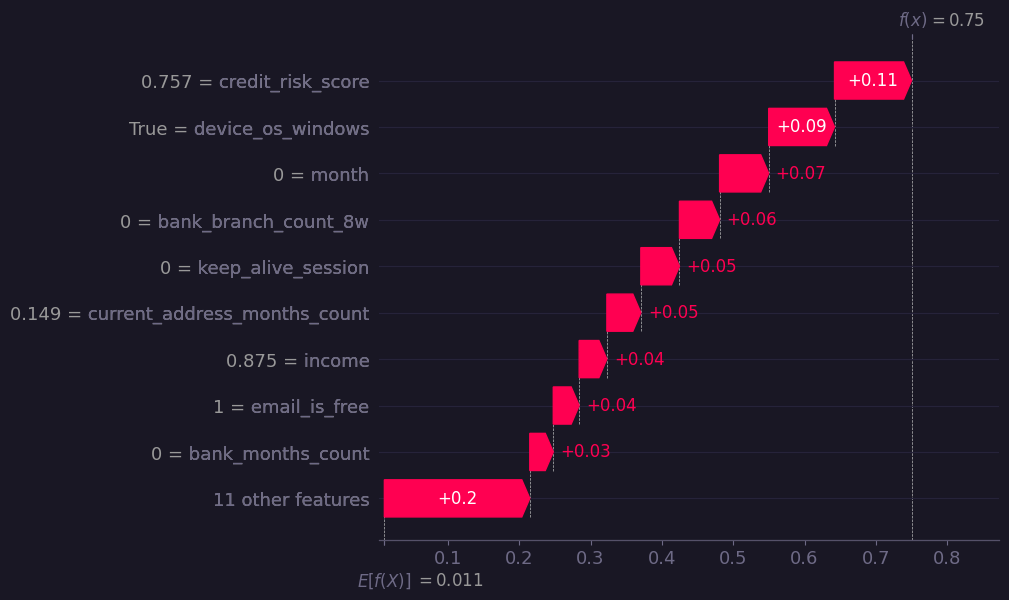

1


In [24]:
# Plot waterfall chart
plot_waterfall(30)

# Print the models prediction
print(sample_pred[30])

-----

## Using OpenAI API


In [25]:
# Insert personal OpenAI API Key
OPENAI_API_KEY = input('Insert OpenAI API Key Here')

Demo script to call the API,  asking ChatGPT how many eggs are in a dozen. 
The API call is wrapped in a user confirmation to retrict the excess calling of the API, limiting the charges.

In [26]:
# Prompt the user for confirmation
user_input = input("Are you sure you want to run the script? (yes/no): ")

# Check the user's response

if user_input.lower() == 'yes':

    # The user confirmed, run the code
    from openai import OpenAI
    client = OpenAI(
        api_key= OPENAI_API_KEY,
    )

    chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{

        "role": "user", 
        "content": "How many eggs in a dozen?"}]

    )   

    message_content = chat_completion.choices[0].message.content

    print(message_content)
    
else:
    print("Script execution canceled.")

There are 12 eggs in a dozen.


-----

## Create single function

Having built all the pieces to help understand the output of the model, we can now pull these all together into one function. Taking in the sample number and returning a full breakdown of the contributing factors to the models decision.

The function will:

1. Take the sample number and check is it within the sample range.
2. Create a dataframe of the features, values and shap values.
3. Plot the waterfall chart.
4. Build the ChatGPT prompt and call the API.
5. Return the plot and the explanation from ChatGPT.

In [27]:
# Function takes in the sample number and provides an explaination of the prediction
def explain_rf_pred(sample_number):

    # Check if the sample_number is within the valid range (0-500)
    if not (0 <= sample_number < len(sample_data)):
        raise ValueError("Sample number should be between 0 and 500.")
    

    # First take the input number and get the sample shap results
    df = pd.DataFrame({'Values': shap_values.values[sample_number][:,1], 'Data': shap_values.data[sample_number]})
    df['top_info_features'] = top_info_features
    df['Rank_Abs_Values'] = df['Values'].abs().rank(ascending=False)
    df = df.sort_values('Rank_Abs_Values').reset_index(drop = True)

    Sample_prediction = sample_pred[sample_number]
    
    # Plot the Waterfall chart
    plot =  shap.plots.waterfall(shap_values[sample_number,:,1])

    # Define is fradulent or not
    if sample_pred[sample_number] == 1:
        prediction_string = "This is a fraudulent transaction."
    
    elif sample_pred[sample_number] == 0:
        prediction_string = "This is not a fraudulent transaction."

    # Make a string of the top 5 values
    df_string = df[0:5].to_string(index=False)

    # Create the input for GPT
    text_input = f"""

                    {prediction_string} \n
                    Below is the dataset of the 5 largest contributing factors to this outcome. \n
                    Values field is the amount it contributes to the outcome, the more positive the more likely it is fraud, the more negative the less likely it is not fraud. \n
                    Data is the normalised data set.\n\n
                    
                    Can you summerise this table into a short text, with no bullet points, explaining why this transaction was classed as this way based on the below information.\n\n
                    
                   {df_string}"""
    

    # GPT API Call
    client = OpenAI(api_key= OPENAI_API_KEY)

    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
        "role": "system",
        "content": "You are a data analyst making observations for executives"  # Define the system context
        },
        
        {
        "role": "user",
        "content": text_input    # Input the main prompt
        },

        {
        "role": "user",
        "content": """Key points to structure the answer.\n                                        
                        Answer in a short paragraph without bullet points.\n
                        Refer to "The Graph" which will be displayed with your response. \n
                        When values are positive, this contirbutes to fraud..\n
                        When values are negative, this contirbutes to genuine transactions..\n
                        Avoid reciting all values in a list manor\n
                        Provide a summary sentence conclusion at the end"""                   # Add Additional instruction
        }
    ],
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0.2,
    presence_penalty=0.2
    )

    # Save the response
    gpt_response = response.choices[0].message.content

    # Deifne wrapper to format response 
    wrapper = textwrap.TextWrapper(width=150) 
    
    # Apply wrapper to response
    word_list = wrapper.wrap(text=gpt_response) 

    # Print each line. 
    for element in word_list: 
        print(element) 

    return plot



---

## Apply Function to Sample Data

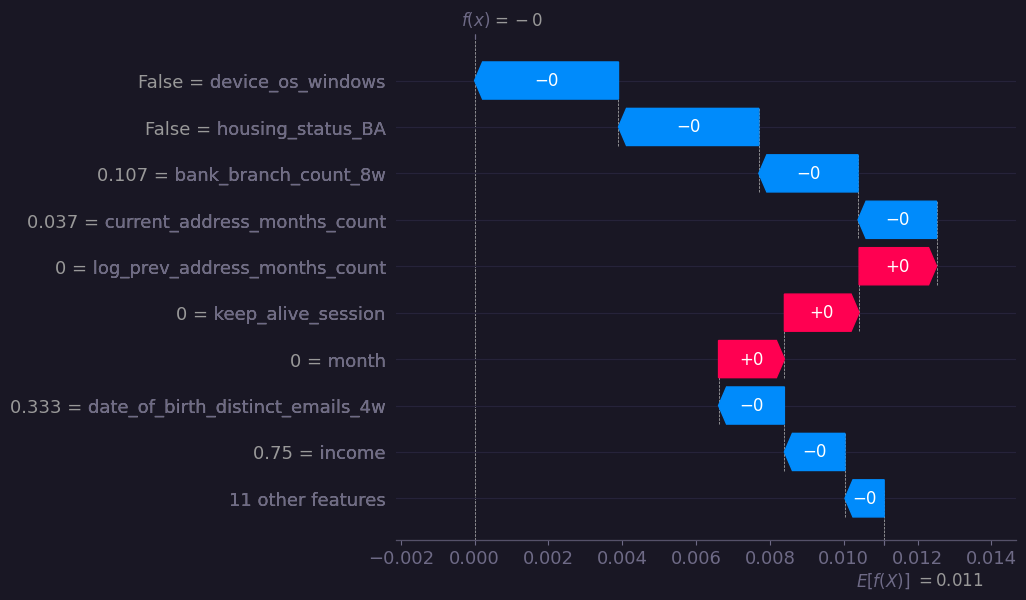

Based on the information provided in the dataset, the transaction in question has been classified as a genuine transaction rather than a fraudulent
one. Several factors contribute to this classification. Firstly, the value of "device_os_windows" has a negative impact on the outcome, indicating
that transactions made from devices with Windows operating system are less likely to be fraudulent. Additionally, the value of "housing_status_BA"
also has a negative impact, suggesting that transactions from individuals with a specific housing status are less likely to be fraudulent.
Furthermore, the values of "bank_branch_count_8w" and "current_address_months_count" have negative impacts as well, indicating that a higher number of
bank branches visited in the past 8 weeks and a longer duration at the current address make the transaction less likely to be fraudulent. Conversely,
the value of "log_prev_address_months_count" has a positive impact, suggesting that having a longer duration at a prev

In [28]:
# Call the function for a non-fraudulent sample
explain_rf_pred(402)

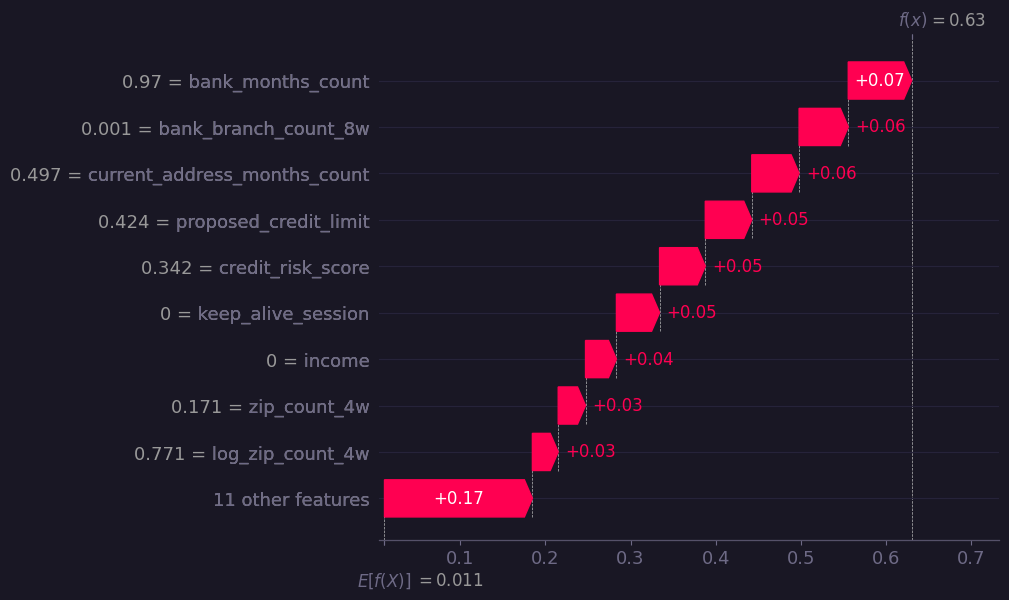

Based on the information provided in the dataset, several factors contribute to why this transaction was classified as fraudulent. The top
contributing factor is the "bank_months_count," with a positive value of 0.074469. This indicates that a longer history with the bank increases the
likelihood of fraud. Following closely is the "bank_branch_count_8w" with a positive value of 0.057720, suggesting that a higher number of branch
visits within the last eight weeks also raises suspicion. The "current_address_months_count" comes next with a positive value of 0.055551, indicating
that a longer duration at the current address is linked to fraudulent activity. Additionally, the "proposed_credit_limit" and the "credit_risk_score"
show positive values of 0.054580 and 0.053658 respectively, suggesting that high credit limits and higher credit risk scores are associated with
potential fraud. Based on these findings, it can be concluded that the transaction was classified as fraudulent due to sev

In [29]:
# Call the function for a fraudulent sample
explain_rf_pred(300)

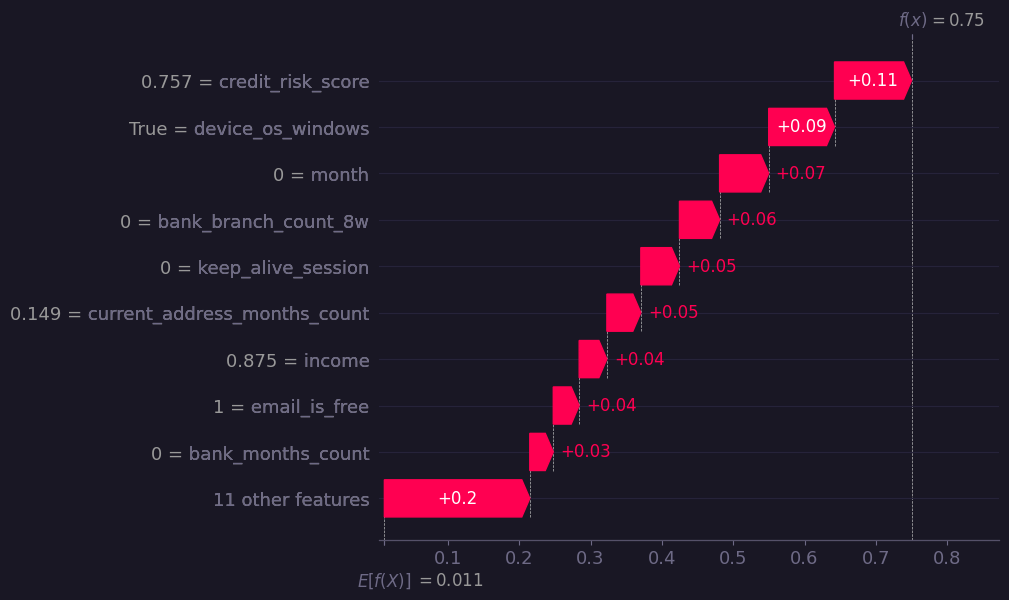

APIConnectionError: Connection error.

In [30]:
# Call the function for a fraudulent sample
explain_rf_pred(30)